In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from random import sample 
import scipy
import scipy.stats
import skimage
from skimage import io
#import glob
import sklearn
from scipy.ndimage import gaussian_filter


##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.tail(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1018,00005306_000.png,Infiltration,0,5306,040Y,F,PA,3056,2460,0.139,0.139
532,00002739_001.png,Fibrosis,1,2739,032Y,M,PA,2500,2048,0.168,0.168
1838,00009710_004.png,Atelectasis,4,9710,053Y,M,AP,2500,2048,0.168,0.168


In [3]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels({}):{}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)        

All Labels(15):['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
83416,00020482_002.png,No Finding,2,20482,29,F,AP,2888,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
30711,00008009_021.png,Effusion|Pleural_Thickening|Pneumothorax,21,8009,18,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
55478,00013894_048.png,Effusion,48,13894,21,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


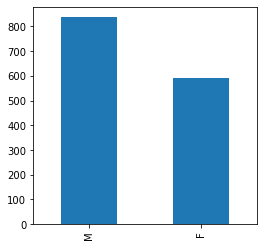

In [4]:
plt.figure(figsize=(4,4))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts()[0:2].plot(kind='bar')

(0.0, 200.0)

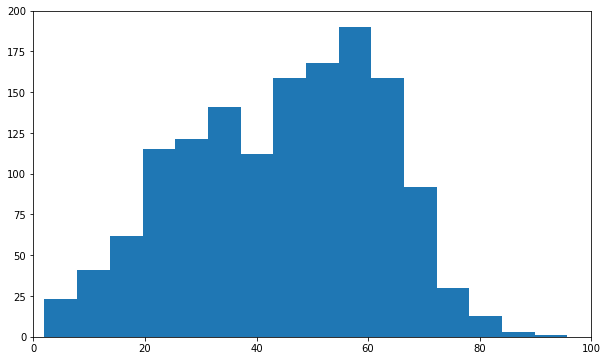

In [5]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], bins=(70))
plt.xlim(xmin=0, xmax=100)
plt.ylim(ymin=0, ymax=200)



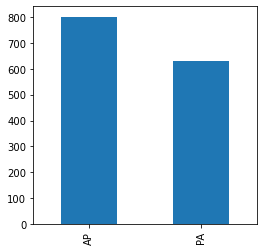

In [6]:
plt.figure(figsize=(4,4))
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts()[0:2].plot(kind='bar')

In [7]:
#number of cases
ax=len(all_xray_df)
ax

112120

In [8]:
#number of pneumonia cases
PC= len(all_xray_df[all_xray_df.Pneumonia==1])
PC

1431

In [9]:
#number of non-pneumonia cases
NPC= len(all_xray_df[all_xray_df.Pneumonia==0])
NPC

110689

In [10]:
all_xray_df[all_labels].sum()

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

In [11]:
all_xray_df[all_xray_df.Pneumonia==1][all_labels].sum()

Atelectasis            262.0
Cardiomegaly            41.0
Consolidation          123.0
Edema                  340.0
Effusion               269.0
Emphysema               23.0
Fibrosis                11.0
Hernia                   3.0
Infiltration           605.0
Mass                    71.0
No Finding               0.0
Nodule                  70.0
Pleural_Thickening      48.0
Pneumonia             1431.0
Pneumothorax            41.0
dtype: float64

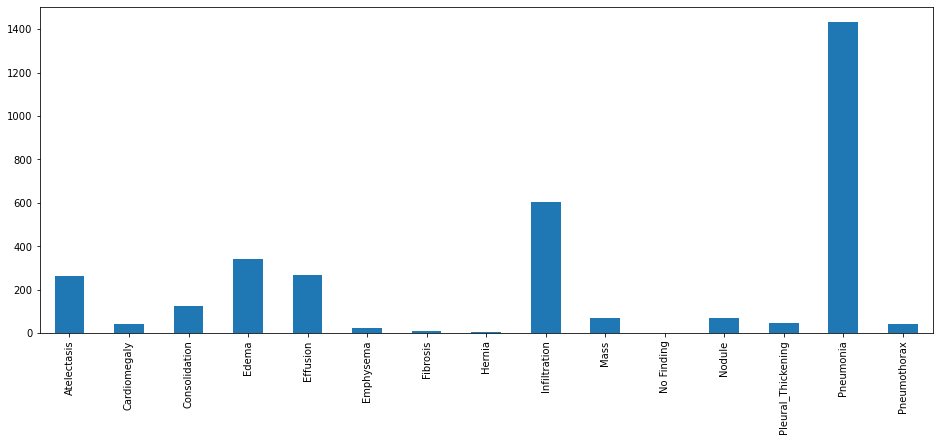

In [12]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1][all_labels].sum().plot(kind='bar')

In [13]:
#Number of disease per patient
all_xray_df['disease_per_patient']= all_xray_df[['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion','Emphysema','Fibrosis','Hernia','Infiltration','Mass','Nodule','Pleural_Thickening','Pneumonia','Pneumothorax']].sum(axis=1)
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_per_patient
44414,00011425_002.png,No Finding,2,11425,53,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
103527,00027631_000.png,Effusion,0,27631,63,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14783,00003863_001.png,No Finding,1,3863,48,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101247,00026892_000.png,No Finding,0,26892,45,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101726,00027038_007.png,No Finding,7,27038,64,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#Pixel-level assessments of the imaging data for healthy & disease states of interest

In [15]:

all_image_paths = {os.path.basename(x): x for x in
                  glob(os.path.join('/data','images*','*','*.png'))}
print('scans found:', len(all_image_paths), ',Total Headers',  sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(10)


scans found: 112120 ,Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2564,00012874_033.png,No Finding,33,12874,063Y,M,PA,2992,2991,0.143000,0.143000,/data/images_006/images/00012874_033.png
2175,00011211_009.png,No Finding,9,11211,073Y,M,PA,2992,2991,0.143000,0.143000,/data/images_005/images/00011211_009.png
284,00001518_000.png,No Finding,0,1518,026Y,M,PA,2992,2991,0.143000,0.143000,/data/images_002/images/00001518_000.png
4471,00022283_029.png,No Finding,29,22283,060Y,F,AP,3056,2544,0.139000,0.139000,/data/images_010/images/00022283_029.png
4789,00025181_006.png,Infiltration,6,25181,054Y,M,PA,2874,2550,0.143000,0.143000,/data/images_011/images/00025181_006.png
882,00004659_000.png,Edema,0,4659,035Y,F,AP,2500,2048,0.171000,0.171000,/data/images_003/images/00004659_000.png
5455,00029679_000.png,Atelectasis,0,29679,042Y,M,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00029679_000.png
138,00000781_006.png,No Finding,6,781,065Y,F,PA,2726,2991,0.143000,0.143000,/data/images_001/images/00000781_006.png
2368,00012010_008.png,Infiltration,8,12010,054Y,M,AP,2500,2048,0.168000,0.168000,/data/images_006/images/00012010_008.png
460,00002412_000.png,Edema,0,2412,062Y,M,AP,2500,2048,0.168000,0.168000,/data/images_002/images/00002412_000.png


In [16]:
healthy = io.imread('/data/images_012/images/00028628_020.png')
pneumonia = io.imread('/data/images_002/images/00001529_004.png')

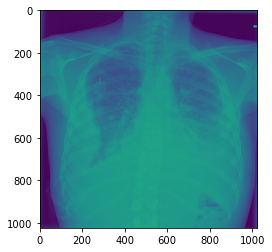

In [17]:
plt.imshow(healthy)

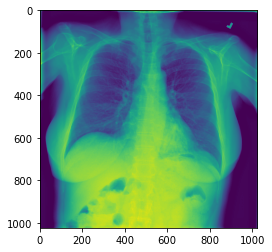

In [18]:
plt.imshow(pneumonia)

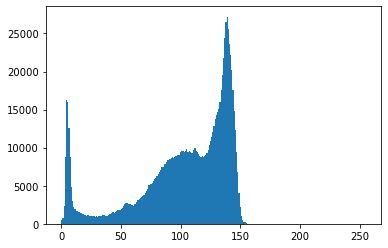

In [19]:
x = plt.hist(healthy.ravel(),bins=256)

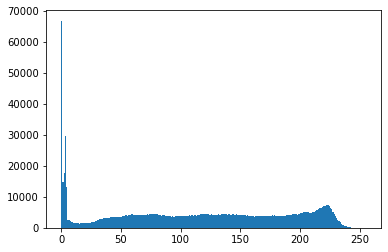

In [20]:
x = plt.hist(pneumonia.ravel(),bins=256)

In [21]:
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels({}):{}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)    

All Labels(15):['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1301,00006818_007.png,No Finding,7,6818,046Y,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4189,00020534_001.png,No Finding,1,20534,056Y,F,PA,2670,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
380,00001990_002.png,Pleural_Thickening,2,1990,072Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
sample_df['disease_per_patient']= sample_df[['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion','Emphysema','Fibrosis','Hernia','Infiltration','Mass','Nodule','Pleural_Thickening','Pneumonia','Pneumothorax']].sum(axis=1)


In [23]:
pnc = sample_df['path'][sample_df.Pneumonia==1]
pnc.sample(3)

3342    /data/images_008/images/00016508_012.png
2522    /data/images_006/images/00012667_000.png
4046    /data/images_009/images/00019938_003.png
Name: path, dtype: object

In [24]:
nfc = sample_df['path'][sample_df.disease_per_patient==3]
nfc.sample(3)

2518    /data/images_006/images/00012648_004.png
5124    /data/images_011/images/00027278_006.png
1852    /data/images_005/images/00009759_002.png
Name: path, dtype: object

In [25]:
sample_df.path[0]

'/data/images_001/images/00000013_005.png'

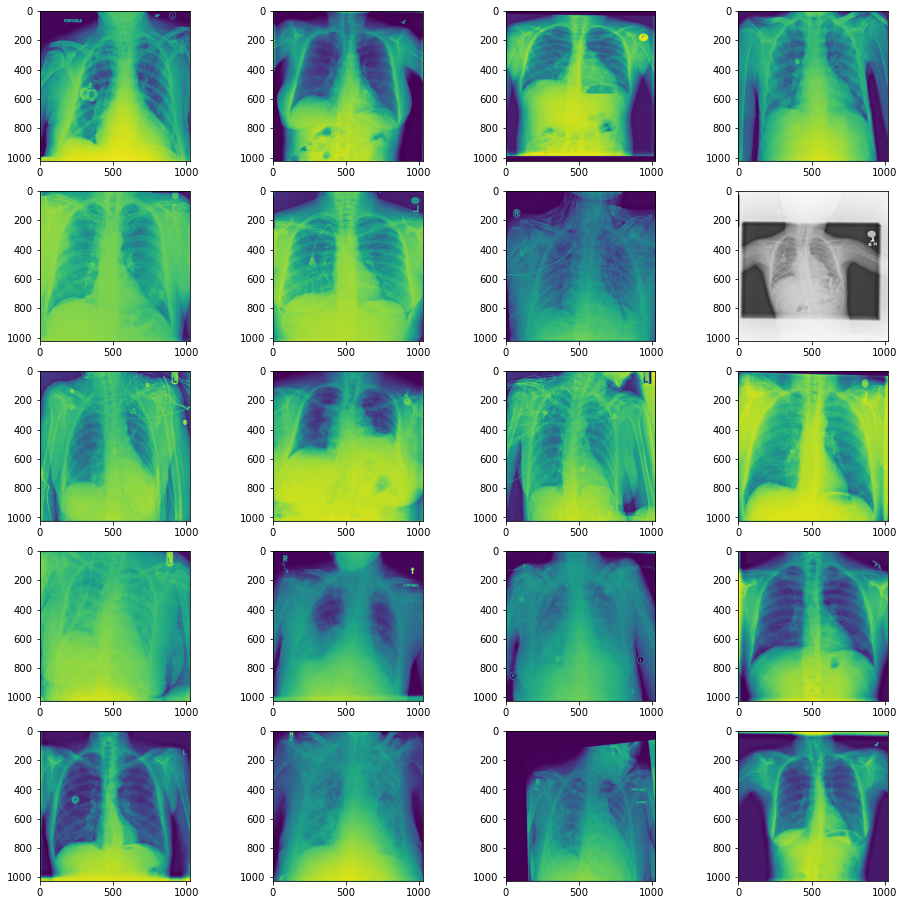

In [26]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = pnc
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img)
    ind=ind+1

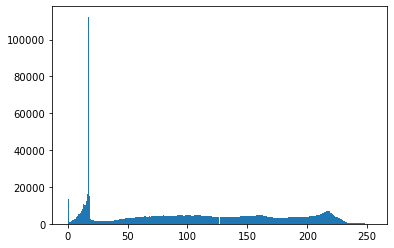

In [27]:
x = plt.hist(img.ravel(),bins=256)

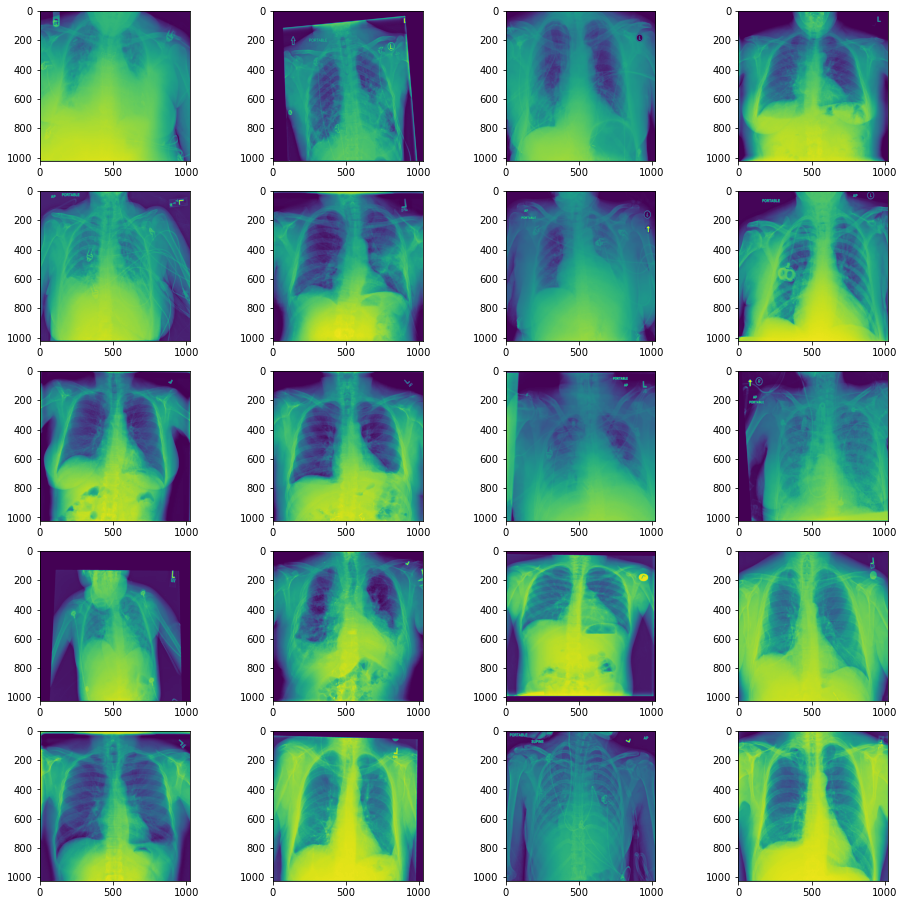

In [28]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imggs = nfc
ind=0

for immg, ax in zip(imggs, m_axs):
    immg = io.imread(immg)
    ax.imshow(immg)
    ind=ind+1

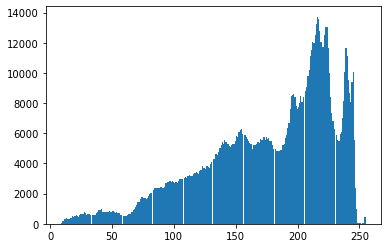

In [29]:
x = plt.hist(immg.ravel(),bins=256)

In [ ]:
# The training model include data of 1431 Pnemunia patients and 60361 healthy patient from different age ranges and sex
# The X-ray Images has two different view position either PA or AP
# Since the principle of this project is to detect the presence or absence of Pneumonia by measuring the X-ray intensities,
#I choase one healthy X-ray and one Pneumonia X-ray there was a clear difference in the intensities  


In [22]:
#Pixel-level assessments of the imaging data for healthy & disease states of interest
dcm = pydicom.dcmread('test3.dcm')

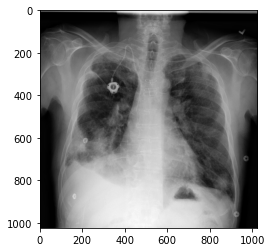

In [23]:
#dcm = pydicom.dcmread('sample_labels.csv')
plt.imshow(dcm.pixel_array,cmap='gray')


(array([3.5061e+04, 8.4770e+03, 1.1659e+04, 1.5547e+04, 2.6001e+04,
        1.2153e+04, 2.3590e+03, 2.1880e+03, 2.2290e+03, 2.0000e+03,
        1.8530e+03, 1.7710e+03, 1.7830e+03, 1.8510e+03, 1.9450e+03,
        1.8240e+03, 1.8270e+03, 1.8310e+03, 1.8620e+03, 1.8820e+03,
        2.1060e+03, 2.0850e+03, 2.1490e+03, 2.2610e+03, 2.3450e+03,
        0.0000e+00, 2.3700e+03, 2.4940e+03, 2.7080e+03, 2.7610e+03,
        2.9390e+03, 2.9560e+03, 2.9950e+03, 3.0180e+03, 3.0560e+03,
        3.2820e+03, 3.3430e+03, 3.4600e+03, 3.5090e+03, 3.7450e+03,
        3.7580e+03, 3.8000e+03, 4.0730e+03, 4.3480e+03, 4.4720e+03,
        4.4720e+03, 4.7580e+03, 4.7250e+03, 4.8530e+03, 4.8440e+03,
        4.8640e+03, 0.0000e+00, 4.8580e+03, 5.0440e+03, 5.1020e+03,
        5.2790e+03, 5.2400e+03, 5.4470e+03, 5.5970e+03, 5.4190e+03,
        5.4440e+03, 5.3410e+03, 5.4730e+03, 5.4880e+03, 5.6010e+03,
        5.7700e+03, 5.7040e+03, 5.7260e+03, 5.8040e+03, 5.8610e+03,
        6.0650e+03, 5.9290e+03, 5.8920e+03, 5.86

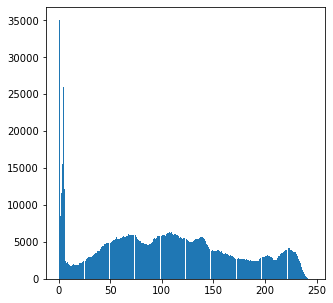

In [24]:
plt.figure(figsize=(5,5))
plt.hist(dcm.pixel_array.ravel(), bins = 256)

In [25]:
mean_intensity = np.mean(dcm.pixel_array)
mean_intensity

104.74800395965576

In [26]:
std_intensity = np.std(dcm.pixel_array)
std_intensity

66.22413614301003

In [27]:
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity

(array([3.5061e+04, 8.4770e+03, 1.1659e+04, 1.5547e+04, 2.6001e+04,
        1.2153e+04, 2.3590e+03, 2.1880e+03, 2.2290e+03, 2.0000e+03,
        1.8530e+03, 1.7710e+03, 1.7830e+03, 1.8510e+03, 1.9450e+03,
        1.8240e+03, 1.8270e+03, 1.8310e+03, 1.8620e+03, 1.8820e+03,
        2.1060e+03, 2.0850e+03, 2.1490e+03, 2.2610e+03, 2.3450e+03,
        0.0000e+00, 2.3700e+03, 2.4940e+03, 2.7080e+03, 2.7610e+03,
        2.9390e+03, 2.9560e+03, 2.9950e+03, 3.0180e+03, 3.0560e+03,
        3.2820e+03, 3.3430e+03, 3.4600e+03, 3.5090e+03, 3.7450e+03,
        3.7580e+03, 3.8000e+03, 4.0730e+03, 4.3480e+03, 4.4720e+03,
        4.4720e+03, 4.7580e+03, 4.7250e+03, 4.8530e+03, 4.8440e+03,
        4.8640e+03, 0.0000e+00, 4.8580e+03, 5.0440e+03, 5.1020e+03,
        5.2790e+03, 5.2400e+03, 5.4470e+03, 5.5970e+03, 5.4190e+03,
        5.4440e+03, 5.3410e+03, 5.4730e+03, 5.4880e+03, 5.6010e+03,
        5.7700e+03, 5.7040e+03, 5.7260e+03, 5.8040e+03, 5.8610e+03,
        6.0650e+03, 5.9290e+03, 5.8920e+03, 5.86

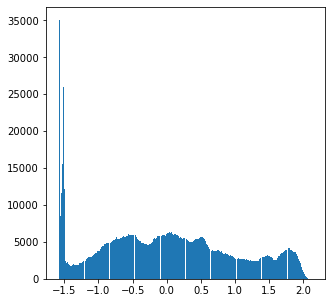

In [28]:
plt.figure(figsize=(5,5))
plt.hist(new_img.ravel(), bins = 256)